# Fetal Health Classification

#### Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
from sklearn import metrics

#### Functions

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

#### Load dataset

In [3]:
df = pd.read_csv("data/fetal_health.csv")

In [4]:
df.columns

Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health'],
      dtype='object')

#### Data analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [6]:
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


<AxesSubplot:xlabel='fetal_health', ylabel='count'>

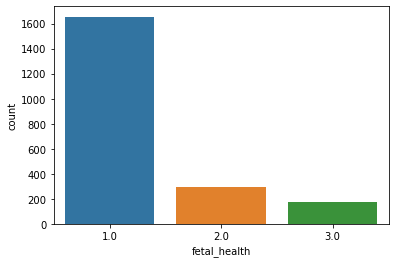

In [7]:
# Target distribution

sns.countplot(x=df["fetal_health"])

Since our target is imbalanced and the purpose of the algorithm is to find the cases where the fetus might have a health issue, we are going to group the suspected and and pathological cases.

In [8]:
df["fetal_health"].value_counts()

1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64

In [9]:
df.loc[df["fetal_health"] == 3] = 2

In [10]:
df["fetal_health"].value_counts()

1.0    1655
2.0     471
Name: fetal_health, dtype: int64

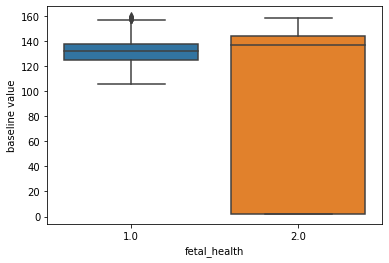

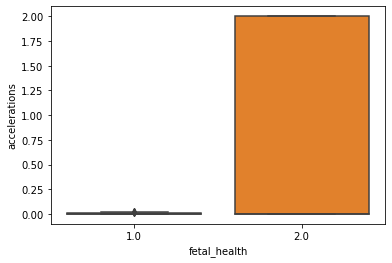

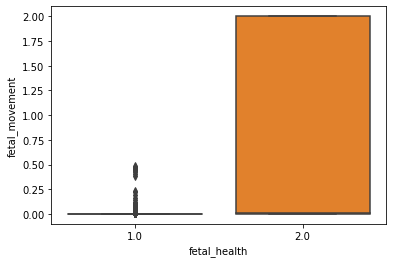

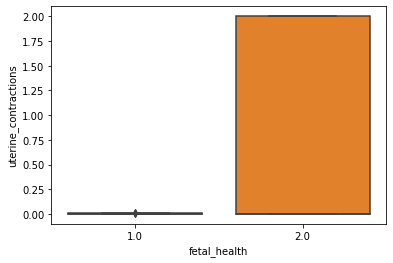

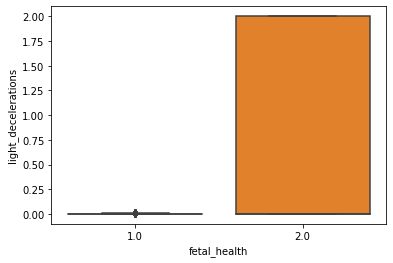

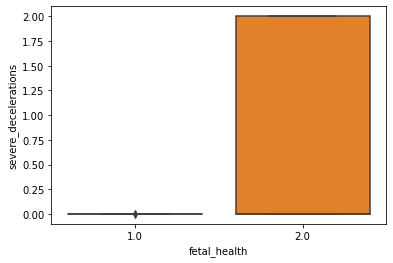

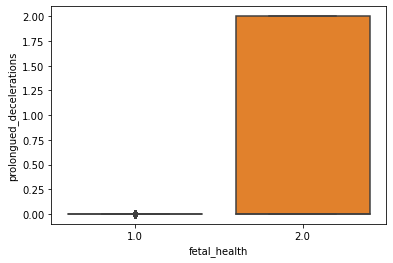

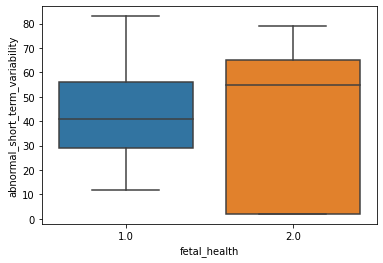

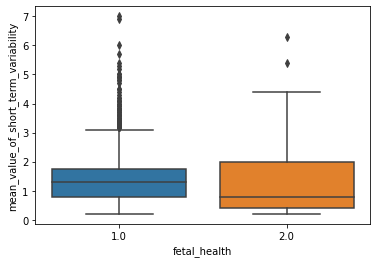

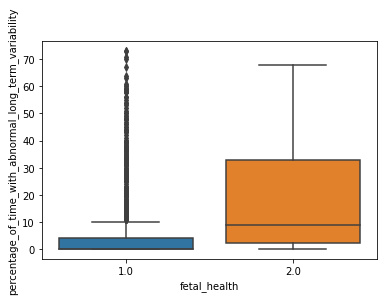

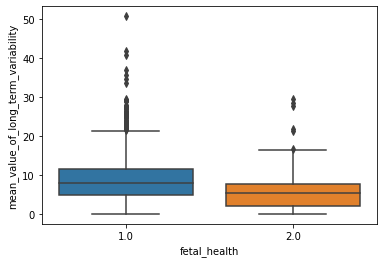

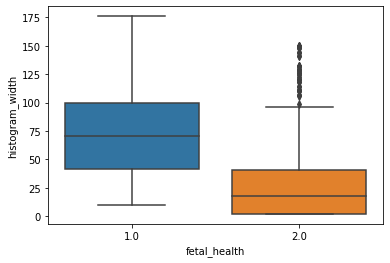

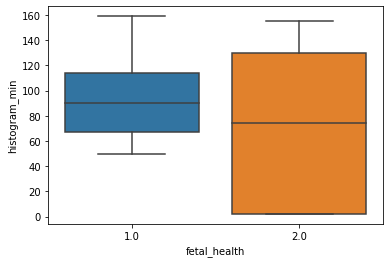

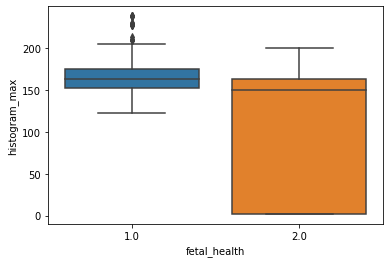

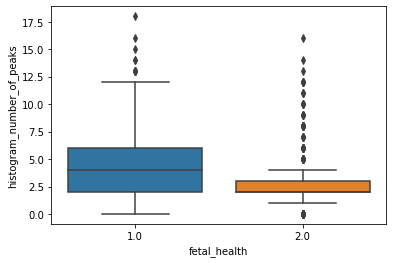

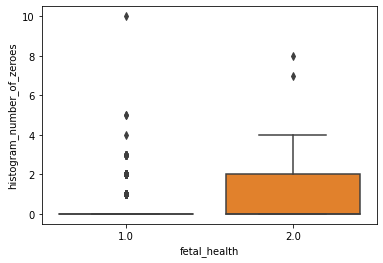

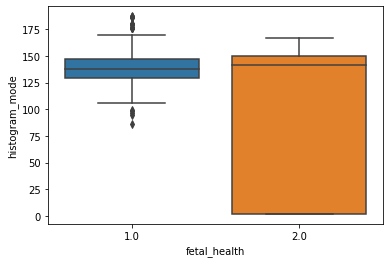

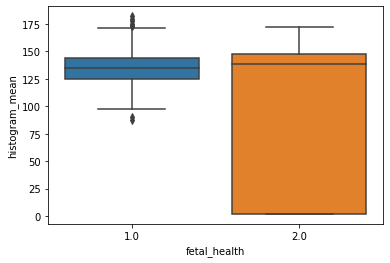

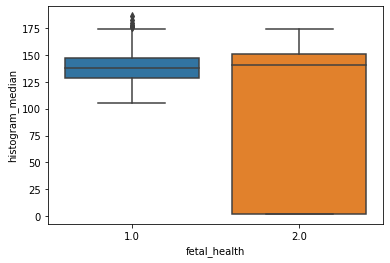

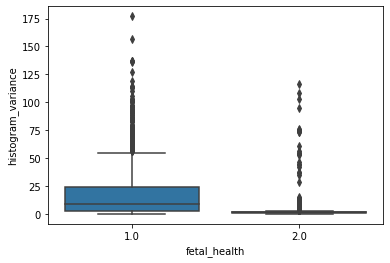

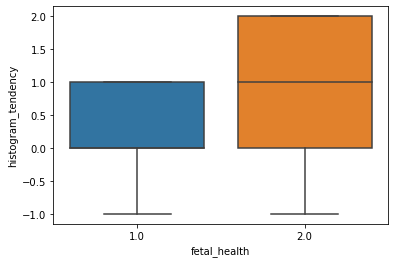

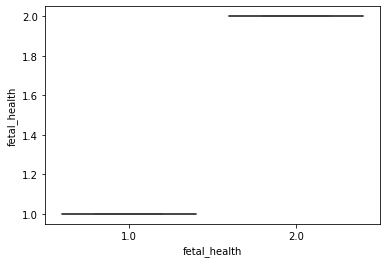

In [11]:
for col in df.columns:
    sns.boxplot(data=df, x="fetal_health", y=col)
    plt.show()

The target distribution indicates that we have an inbalanced dataset.

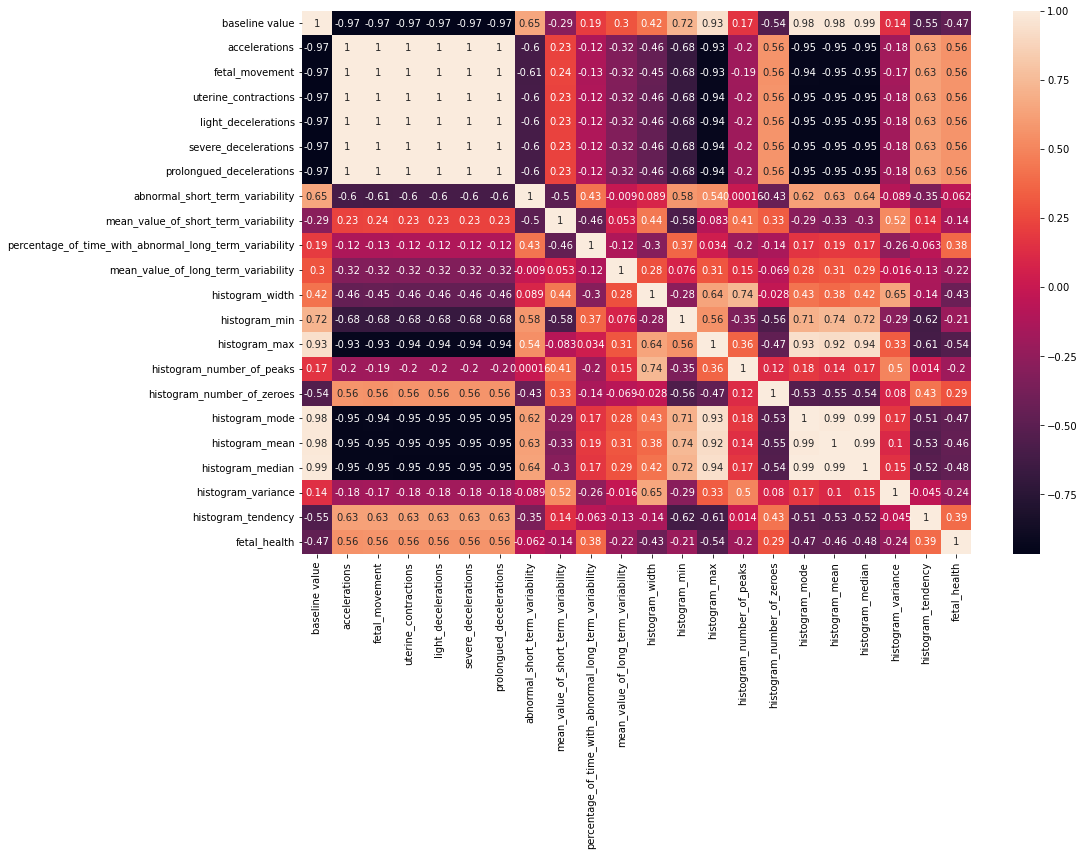

In [12]:
# correlation matrix
corr_matrix = df.corr()

fig = plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

#### Feature selection

In [13]:
corr_matrix["fetal_health"].sort_values()

histogram_max                                            -0.539124
histogram_median                                         -0.475115
histogram_mode                                           -0.474558
baseline value                                           -0.471423
histogram_mean                                           -0.463383
histogram_width                                          -0.426527
histogram_variance                                       -0.236519
mean_value_of_long_term_variability                      -0.216252
histogram_min                                            -0.213726
histogram_number_of_peaks                                -0.195846
mean_value_of_short_term_variability                     -0.141310
abnormal_short_term_variability                          -0.061711
histogram_number_of_zeroes                                0.285608
percentage_of_time_with_abnormal_long_term_variability    0.379164
histogram_tendency                                        0.38

When analyzing the correlations between the features and the target (fetal_health), we have:
- accelerations, fetal_movement, uterine_contractions, light_decelerations, severe_decelerations, prolongued_decelerations have the highest correlation scores
- histogram_max has a high negative correlation with our target

Those features will be used to train our model

#### Split data

In [14]:
X = df[["accelerations", "fetal_movement", "uterine_contractions", "light_decelerations", "severe_decelerations", "prolongued_decelerations"]]
y = df["fetal_health"]

In [15]:
y.value_counts()

1.0    1655
2.0     471
Name: fetal_health, dtype: int64

In [16]:
#Use label encoder on target
le = LabelEncoder()
y = le.fit_transform(y)

#Divide train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Model baseline

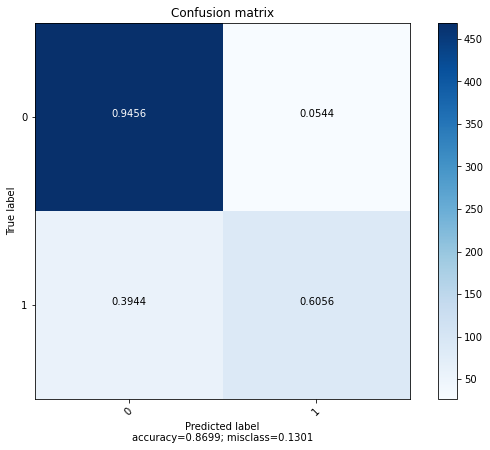

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       496
           1       0.76      0.61      0.67       142

    accuracy                           0.87       638
   macro avg       0.83      0.78      0.80       638
weighted avg       0.86      0.87      0.86       638



In [17]:
# Baseline model of xgboost with default parameters

model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

# make predictions for test data
y_pred = model_xgb.predict(X_test)


# confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_matrix, target_names=["0", "1"])

# evaluate predictions
print(classification_report(y_test, y_pred, zero_division=1))

#### Model improvement

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


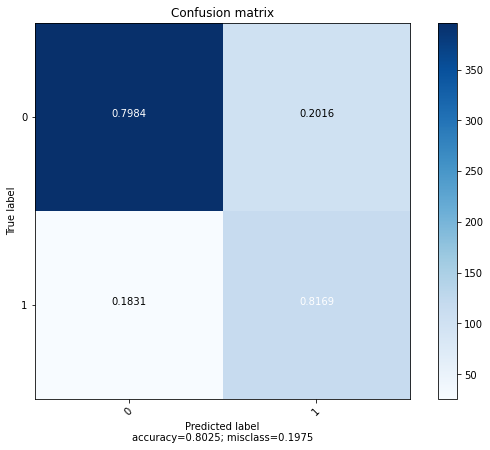

Best hyperparameters:  {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 7, 'xgb__n_estimators': 50, 'xgb__scale_pos_weight': 3.51, 'xgb__subsample': 1.0}
Best score:  0.8812587412587412
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       496
           1       0.54      0.82      0.65       142

    accuracy                           0.80       638
   macro avg       0.74      0.81      0.76       638
weighted avg       0.85      0.80      0.81       638



In [18]:
# Define your pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier())
])

# Define hyperparameters for GridSearchCV
params = {
    'xgb__scale_pos_weight': [3.51],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__learning_rate': [0.01, 0.1, 0.5],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.5, 0.8, 1.0],
    'xgb__colsample_bytree': [0.5, 0.8, 1.0]
}


# Define GridSearchCV object
grid_search = GridSearchCV(pipeline, params, cv=5, scoring='recall', n_jobs=-1, verbose=1)

# Fit GridSearchCV object to your training data
grid_search.fit(X_train, y_train)

# Evaluate model on test data
y_pred = grid_search.predict(X_test)

# Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_matrix, target_names=["0", "1"])

# Print the best hyperparameters and score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print(classification_report(y_test, y_pred, zero_division=1))
